In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from pprint import pprint

In [2]:
# 数据预处理函数
def preprocess(x, y):
    x = tf.cast(x, dtype=tf.float32) / 255.
    x = tf.reshape(x, [-1, 32, 32, 1])
    y = tf.one_hot(y, depth=10)  # one_hot 编码
    return x, y

In [7]:
# 加载数据集
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
pprint(x_train)
print(x_train.shape)

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [8]:
# 样本图像周围补0（上下左右均补2个0），将28*28的图像转成32*32的图像
paddings = tf.constant([[0, 0], [2, 2], [2, 2]])
x_train = tf.pad(x_train, paddings)
x_test = tf.pad(x_test, paddings)

x_train.shape

TensorShape([60000, 32, 32])

In [9]:
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_db = train_db.shuffle(10000)  # 打乱训练集样本
train_db = train_db.batch(128)
train_db = train_db.map(preprocess)

test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_db = test_db.shuffle(10000)  # 打乱测试集样本
test_db = test_db.batch(128)
test_db = test_db.map(preprocess)

batch = 32


In [10]:
# 创建模型
model = keras.Sequential([
    # 卷积层1
    keras.layers.Conv2D(6, 5),  # 使用6个5*5的卷积核对单通道32*32的图片进行卷积，结果得到6个28*28的特征图
    keras.layers.MaxPooling2D(pool_size=2, strides=2),  # 对28*28的特征图进行2*2最大池化，得到14*14的特征图
    keras.layers.ReLU(),  # ReLU激活函数
    # 卷积层2
    keras.layers.Conv2D(16, 5),  # 使用16个5*5的卷积核对6通道14*14的图片进行卷积，结果得到16个10*10的特征图
    keras.layers.MaxPooling2D(pool_size=2, strides=2),  # 对10*10的特征图进行2*2最大池化，得到5*5的特征图
    keras.layers.ReLU(),  # ReLU激活函数
    # 卷积层3
    keras.layers.Conv2D(120, 5),  # 使用120个5*5的卷积核对16通道5*5的图片进行卷积，结果得到120个1*1的特征图
    keras.layers.ReLU(),  # ReLU激活函数
    # 将 (None, 1, 1, 120) 的下采样图片拉伸成 (None, 120) 的形状
    keras.layers.Flatten(),
    # 全连接层1
    keras.layers.Dense(84, activation='relu'),  # 120*84
    # 全连接层2
    keras.layers.Dense(10, activation='softmax')  # 84*10
])
model.build(input_shape=(batch, 32, 32, 1))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (32, 28, 28, 6)           156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 14, 14, 6)           0         
_________________________________________________________________
re_lu (ReLU)                 (32, 14, 14, 6)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 10, 10, 16)          2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 5, 5, 16)            0         
_________________________________________________________________
re_lu_1 (ReLU)               (32, 5, 5, 16)            0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 1, 1, 120)           4

In [11]:
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
# 训练
history = model.fit(train_db, epochs=50)

Epoch 1/50
469/469 [==============================] - 13s 27ms/step - loss: 1.0030 - accuracy: 0.6376
Epoch 2/50
469/469 [==============================] - 13s 28ms/step - loss: 0.4793 - accuracy: 0.8280
Epoch 3/50
469/469 [==============================] - 13s 27ms/step - loss: 0.3976 - accuracy: 0.8566
Epoch 4/50
469/469 [==============================] - 13s 27ms/step - loss: 0.3566 - accuracy: 0.8721
Epoch 5/50
469/469 [==============================] - 14s 29ms/step - loss: 0.3260 - accuracy: 0.8814
Epoch 6/50
469/469 [==============================] - 13s 28ms/step - loss: 0.3086 - accuracy: 0.8882
Epoch 7/50
469/469 [==============================] - 15s 33ms/step - loss: 0.2872 - accuracy: 0.8938
Epoch 8/50
469/469 [==============================] - 15s 32ms/step - loss: 0.2738 - accuracy: 0.9002
Epoch 9/50
469/469 [==============================] - 14s 29ms/step - loss: 0.2581 - accuracy: 0.9043
Epoch 10/50
469/469 [==============================] - 14s 29ms/step - loss: 0.250

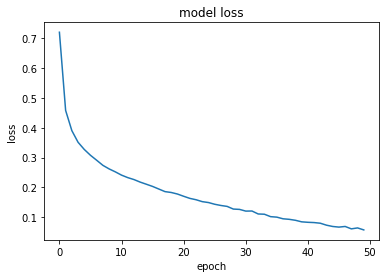

In [12]:
# 损失下降曲线
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [13]:
# 测试
model.evaluate(test_db)

79/79 [==============================] - 1s 7ms/step - loss: 0.4905 - accuracy: 0.9007


[0.49052295088768005, 0.9006999731063843]